In [1]:
#####################################################################################################################
#Developed by Jonathan Ojeda 8/1/2021 QAAFI UQ
# Code functionalities:
# In order to study the interactions between G and M under different climate conditions, climate zones
# can be created by kmeans clustering (Arthur and Vassilvitskii, 2007). The clustering is applied separately 
# to average mean daily temperature, sum solar radiation and rainfall during the crop growing season.

#Arthur, D., Vassilvitskii, S., 2007. k-means + +: the advantages of careful seeding.
#In: Proceedings of the Eighteenth Annual ACM-SIAM Symposium on Discrete
#Algorithms Society for Industrial and Applied Mathematics, New Orleans,
#Louisiana, pp. 1027–1035.
#####################################################################################################################

In [157]:
#import libraries
import random as rd
import os
import sqlite3
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import dateutil
import pylab as py
import seaborn as sns
import scipy 
from scipy import stats
import sklearn.metrics
from numpy  import array
import glob
import functools
from functools import reduce
import matplotlib.ticker as ticker
import cartopy.io.shapereader as shpreader
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib as mpl
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
from matplotlib.colors import LinearSegmentedColormap

from sklearn.cluster import KMeans

#Extend screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [91]:
#Read mean created using nco from Linux
#data0 = xr.open_dataset(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\outputs\new\mean.nc', decode_times=False)

#Read output from psims
data00 = xr.open_dataset(r'C:/Users/uqjojeda/Nextcloud/PURTERRA-A0131/2020/outputs/new/run004/all.nc', decode_times=False) 

# replace all values equal to -99 with np.nan
#data_mean = data0.where(data0['biomass'] != -99.)
dataPre4 = data00.where(data00['biomass'] != -99.)
dataPre3 = dataPre4.where(dataPre4['FloweringDAS'] != -99.)
dataPre2 = dataPre3.where(dataPre3['MaxLAI'] != -99.)

# Extract single lat/long combination for a particular variable
data2 = dataPre2.where(dataPre2.biomass != dataPre2.biomass[8,0:,0:,73,0:], drop=True)

#Conver multidimendional frame to 2D frame
data2pd = data2.to_dataframe()
dfc = data2pd[data2pd.biomass != 0]
dfc.reset_index(level=[0,1,2,3,4], inplace=True)

#Change name of column
dfc.rename(columns={'scen_new':'cultivar'}, inplace=True)
df = dfc.dropna()
df0 = df.where(df['biomass'] != 0)
X=df0.groupby(['lat','lon'])[['RadiationIn','TempIn','RainIn','biomass']].mean()

In [92]:
#Calculate clusters using k-means

kmeans = KMeans(n_clusters=3, n_init=200) #algorithm='elkan'

y = kmeans.fit_predict(X[['RadiationIn','TempIn','RainIn']])

X['env'] = y
#print(X)

In [93]:
#Calculate means and SD for Rad, Rain and Temp in each environment
mean_env = X.groupby(['env'])[['RadiationIn','TempIn','RainIn']].mean().round(decimals=2)
mean_env.rename(columns={'RadiationIn':'RadiationIn_m','TempIn':'TempIn_m','RainIn':'RainIn_m'}, inplace=True)

sd_env = X.groupby(['env'])[['RadiationIn','TempIn','RainIn']].std().round(decimals=2)
sd_env.rename(columns={'RadiationIn':'RadiationIn_sd','TempIn':'TempIn_sd','RainIn':'RainIn_sd'}, inplace=True)
sd_env

envs = pd.concat([mean_env, sd_env], axis=1)
#envs.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\envs2.csv')

In [211]:
envs

,RadiationIn_m,TempIn_m,RainIn_m,RadiationIn_sd,TempIn_sd,RainIn_sd
env,,,,,,
0,1941.780029,25.600000,341.329987,122.77,1.69,67.60
1,2704.139893,22.370001,243.009995,161.96,3.34,69.08
2,2350.370117,21.170000,348.980011,106.80,3.10,68.78


KeyError: 0

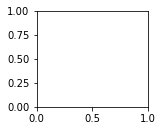

In [203]:
color_dict = dict({'A':'#0000fe','B':'#00ff01','C': '#ff0101'})

fig= plt.figure(figsize=(2,6))

plt.subplot(3, 1, 1)
ax=sns.boxplot(x="env", order=[0,2,1], y="RadiationIn", data=X, 
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('Rad ($MJ\,m^{-2}$)', fontsize =13)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=13)
ax.yaxis.set_major_locator(ticker.MultipleLocator(500))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tick_params(axis='x',bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.subplot(3, 1, 2)
ax=sns.boxplot(x="env", order=[0,2,1], y="TempIn", data=X, 
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('MeanTemp ($^\circ$C)', fontsize =13)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=13)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tick_params(axis='x',bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.subplot(3, 1, 3)
ax=sns.boxplot(x="env", order=[0,2,1], y="RainIn", data=X, 
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('Rain (mm)', fontsize =13)
plt.xlabel('')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=13)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_major_locator(ticker.MultipleLocator(150))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

pos   = [0,2,1]
label = ['A','B','C']
ax.set_xticks(pos)
ax.set_xticklabels(label)

plt.subplots_adjust(wspace=0, hspace=0.08)
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\envs_clim.png', dpi=600,bbox_inches='tight')

In [217]:
#Create name for environments
X.loc[X.env == 0, 'env_name'] = "C"
X.loc[X.env == 2, 'env_name'] = "B"
X.loc[X.env == 1, 'env_name'] = "A"

In [218]:
#Convert dataframe to xarray to plot
df_env = X.to_xarray()
df_env

<xarray.Dataset>
Dimensions:      (lat: 50, lon: 60)
Coordinates:
  * lat          (lat) float64 25.25 25.75 26.25 26.75 ... 48.75 49.25 49.75
  * lon          (lon) float64 -105.8 -105.2 -104.8 ... -77.25 -76.75 -76.25
Data variables:
    RadiationIn  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    TempIn       (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    RainIn       (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    biomass      (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    env          (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    env_name     (lat, lon) object nan nan nan nan nan ... nan nan nan nan nan

In [61]:
df_env.env[0:,0:].values.shape

(50, 60)

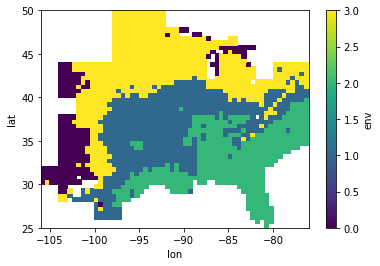

In [77]:
df_env.env[0:,0:].plot(yincrease=True, x='lon', y='lat')

C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
<ipython-input-219-22be13b99e02>:61: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


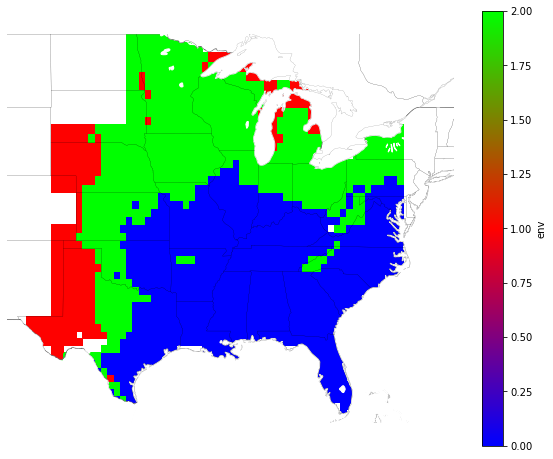

In [219]:
#Plotting map with environmental zones
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=-95)),figsize=(10,8))

colors = [(0, 0, 1), (1, 0, 0),(0, 1, 0)]  # R -> G -> B
n_bins = [3, 6, 10, 100]  # Discretizes the interpolation into bins
cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, colors)

p=df_env.env.plot(x='lon', y='lat', transform=ccrs.PlateCarree(central_longitude=0),
robust=True, cmap=cm, add_colorbar=True, zorder=1, vmin=0, vmax=2)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',
                                  name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, 
                              alpha = 1.00, linewidth =0.01, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                draw_labels=False,dms=True, x_inline=False, y_inline=False)
#ax.coastlines(color='white',linewidth=0.3, zorder=4)
ax.add_feature(cfeature.COASTLINE, color='k')
ax.add_feature(cfeature.STATES, linewidth=0.1, zorder=3)
ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
ax.add_feature(cfeature.BORDERS, color='grey')
ax.add_feature(cfeature.LAND, color='white',zorder=0.5)
ax.set_extent([-107.5, -72, 24.5, 49], crs=ccrs.PlateCarree())
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlocator = mticker.FixedLocator([-100, -90, -80])
gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}

for value in iso3 :
    area(ax, value, "white")

area(ax, value, "white")

#Colorbar attributes
# cb = plt.colorbar(p, orientation="horizontal", pad=0.05, shrink=0.55, ticks=[0,1,2,3])
# cb.set_label(label='', size='xx-large', weight='bold', labelpad=50)
# cb.ax.tick_params(labelsize='x-large')
# cb.set_ticks([])

#fig.text(0.36, 0.19, 'HLL', va='center', rotation='horizontal', fontsize =17)
#fig.text(0.49, 0.19, 'LHH', va='center', rotation='horizontal', fontsize =17)
#fig.text(0.63, 0.19, 'MLM', va='center', rotation='horizontal', fontsize =17)
#fig.text(0.63, 0.19, 'MLM', va='center', rotation='horizontal', fontsize =17)

ax.outline_patch.set_visible(False)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\MAP.png', dpi=600, bbox_inches='tight', pad_inches=0)

In [220]:
X.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\dfenv.csv')

In [221]:
#Merge dataframes to integrate the environment column with other variables
new = pd.merge(X, df0, how ='inner', on =['lat','lon']) 
new2=new.drop(['RadiationIn_y','TempIn_y','RainIn_y','biomass_x'], axis=1)
new2.rename(columns={'RadiationIn_x':'RadiationIn','TempIn_x':'TempIn','RainIn_x':'RainIn','biomass_y':'biomass'}, inplace=True)

#Change name of environments accordingly with levels of rad, rain and temp

new2.loc[new2.irr == 1, 'irr_name'] = "rainfed"
new2.loc[new2.irr == 2, 'irr_name'] = "irrigated"

new2.loc[new2.cultivar == 0, 'cv'] = "GS"
new2.loc[new2.cultivar == 1, 'cv'] = "FS"
new2.loc[new2.cultivar == 2, 'cv'] = "SS"
new2.loc[new2.cultivar == 3, 'cv'] = "FSPS"

new2

,lat,lon,RadiationIn,TempIn,RainIn,env,env_name,irr,cultivar,time,...,aMaxT,aMinT,actual_ET,biomass,planting_date,potential_ET,radInt,scen,irr_name,cv
0,25.25,-80.75,1608.909180,28.082926,484.453918,0,C,1,0,1,...,31.090000,25.056999,202.283997,8899.200195,145.0,360.669006,822.458008,1.0,rainfed,GS
1,25.25,-80.75,1608.909180,28.082926,484.453918,0,C,1,0,2,...,31.579000,25.539000,216.845001,9188.099609,144.0,359.911987,844.252991,1.0,rainfed,GS
2,25.25,-80.75,1608.909180,28.082926,484.453918,0,C,1,0,3,...,30.809999,25.382000,223.789993,8614.099609,144.0,340.734985,795.187988,1.0,rainfed,GS
3,25.25,-80.75,1608.909180,28.082926,484.453918,0,C,1,0,4,...,31.011000,25.243000,209.835999,9249.299805,144.0,360.332001,852.486023,1.0,rainfed,GS
4,25.25,-80.75,1608.909180,28.082926,484.453918,0,C,1,0,5,...,29.686001,24.367001,196.636002,9360.900391,145.0,368.787994,868.437012,1.0,rainfed,GS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428195,49.75,-92.25,2270.501221,16.870274,371.149261,2,B,2,3,23,...,23.931999,13.037000,366.902008,13945.200195,148.0,487.200012,1104.785034,4.0,irrigated,FSPS
428196,49.75,-92.25,2270.501221,16.870274,371.149261,2,B,2,3,24,...,23.698000,12.014000,423.138000,12828.599609,148.0,482.057007,1026.712036,4.0,irrigated,FSPS
428197,49.75,-92.25,2270.501221,16.870274,371.149261,2,B,2,3,26,...,22.441000,11.509000,297.139008,11798.900391,148.0,467.368988,1115.459961,4.0,irrigated,FSPS
428198,49.75,-92.25,2270.501221,16.870274,371.149261,2,B,2,3,27,...,24.410000,11.900000,382.436005,14046.299805,148.0,514.559021,1149.248047,4.0,irrigated,FSPS


<AxesSubplot:ylabel='Frequency'>

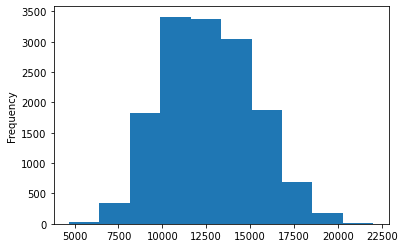

In [66]:
#Calculate means before the plot
mean=new2.groupby(['env_name','irr_name'])[['biomass']].mean().round(decimals=0)

a=new2.groupby(['env_name','irr_name','cultivar','lat','lon'])[['biomass']].mean().round(decimals=0)
a.biomass.plot.hist()

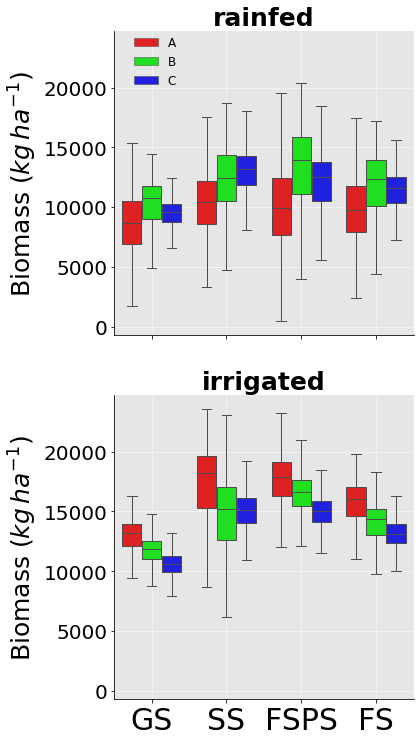

In [228]:
#Plot biomass by environment, cultivar and irrigation management
color_dict = dict({'A':'#ff0101','B':'#00ff01','C': '#0000fe'})

tkt_plot_detailed =sns.catplot(x="cv", order=['GS','SS','FSPS','FS'], y="biomass", data=new2, hue='env_name', 
                               hue_order=['A','B','C'], linewidth=1, kind='box', col='irr_name', 
                               col_wrap=1, legend=False, showfliers = False, palette=color_dict)

tkt_plot_detailed.set_axis_labels("", "Biomass ($kg\,ha^{-1}$)",fontsize= 25)
tkt_plot_detailed.set_titles(col_template="{col_name}", fontweight='bold', size=25)

for ax in tkt_plot_detailed.axes.flatten():

    ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
    ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
    ax.patch.set_facecolor('0.90')
    ax.set_axisbelow(True)
    ax.yaxis.set_tick_params(labelsize=20)
    ax.xaxis.set_tick_params(labelsize=30)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
    pos   = [0, 1, 2, 3]
    label = ['GS','SS','FSPS','FS']
    ax.set_xticks(pos)
    ax.set_xticklabels(label)

plt.legend(prop=dict(size=12),bbox_to_anchor=(0.05, 2.2), loc=2, borderaxespad=0., frameon=False)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\envs.png', dpi=300,bbox_inches='tight')

In [170]:
new2.biomass2.describe()

count    428200.000000
mean         12.705627
std           2.951719
min           0.017000
25%          10.652901
50%          12.701700
75%          14.780100
max          23.559301
Name: biomass2, dtype: float64

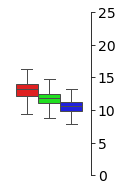

In [230]:
#Create subset of dataframes to create singular plots for biomass
new2['biomass2']=new2['biomass']/1000

rainfed = new2.where(new2['irr_name'] == 'rainfed')
irrigated = new2.where(new2['irr_name'] == 'irrigated')

GSd = rainfed.where(rainfed['cv'] == 'GS')
SSd = rainfed.where(rainfed['cv'] == 'SS')
FSPSd = rainfed.where(rainfed['cv'] == 'FSPS')
FSd = rainfed.where(rainfed['cv'] == 'FS')

GSi = irrigated.where(irrigated['cv'] == 'GS')
SSi = irrigated.where(irrigated['cv'] == 'SS')
FSPSi = irrigated.where(irrigated['cv'] == 'FSPS')
FSi = irrigated.where(irrigated['cv'] == 'FS')

#Plot biomass by environment, cultivar and irrigation management

fig = plt.figure(figsize=(1.5,3))
color_dict = dict({'A':'#ff0101','B':'#00ff01','C': '#0000fe'})
ax=sns.boxplot(x="cv", y="biomass2", data=GSi, hue='env_name', hue_order=['A','B','C'], linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('', fontsize =13)
plt.xlabel('', fontsize =13)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=14, rotation=0)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tick_params(axis='x',bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.get_legend().remove()
ax.set_ylim([0,25])

fig.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\env1.png', dpi=300,bbox_inches='tight',transparent=True)

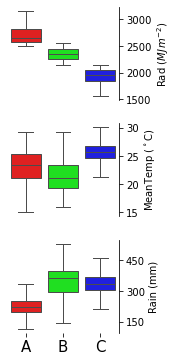

In [233]:
color_dict = dict({'A':'#ff0101','B':'#00ff01','C': '#0000fe'})

fig= plt.figure(figsize=(2,6))

plt.subplot(3, 1, 1)
ax=sns.boxplot(x="env_name", order=['A','B','C'], y="RadiationIn", data=new2, 
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('Rad ($MJ\,m^{-2}$)', fontsize =10)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=10)
ax.yaxis.set_major_locator(ticker.MultipleLocator(500))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tick_params(axis='x',bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)

plt.subplot(3, 1, 2)
ax=sns.boxplot(x="env_name", order=['A','B','C'], y="TempIn", data=new2, 
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('MeanTemp ($^\circ$C)', fontsize =10)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=10)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tick_params(axis='x',bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)

plt.subplot(3, 1, 3)
ax=sns.boxplot(x="env_name", order=['A','B','C'], y="RainIn", data=new2, 
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('Rain (mm)', fontsize =10)
plt.xlabel('')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=10)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_major_locator(ticker.MultipleLocator(150))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.subplots_adjust(wspace=0, hspace=0.25)
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\envs_clim.png', dpi=600,bbox_inches='tight')

In [31]:
new2b=new2.groupby(['cultivar','irr'])[['biomass']].quantile(0.01)
new2b

biomass
cultivar irr              
0        1     4522.975840
         2     8633.107969
1        1     5044.204072
         2    12352.100391
2        1     5300.410181
         2    10680.364033
3        1     6126.927910
         2    11352.199609

In [33]:
new2c=new2.groupby(['cultivar','irr'])[['biomass']].quantile(0.99)
new2c

biomass
cultivar irr              
0        1    13560.607891
         2    16816.863438
1        1    18325.199219
         2    23337.612734
2        1    16062.354834
         2    20272.241133
3        1    17541.923984
         2    22173.590000

In [17]:
#Saving xarray as nc file
#df_env.to_netcdf(r"C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\env.nc")